In [260]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


Objective: Leverage the uncertainty quantification to select informative data points on which the source function is evaluated.

Method: A basic grid is defined, on which the uncertainty is quantified. Source function evaluations are added in an uncertainty-ignorant manner, and an uncertainty-informed manner. The numerical error is examined in both cases.

### 0. Solutions to the TOV-Equations and Source/Matter Terms

In [261]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Flag to avoid internal check visualizations
flag_check_visualization = True


Valid discretization refinement: True


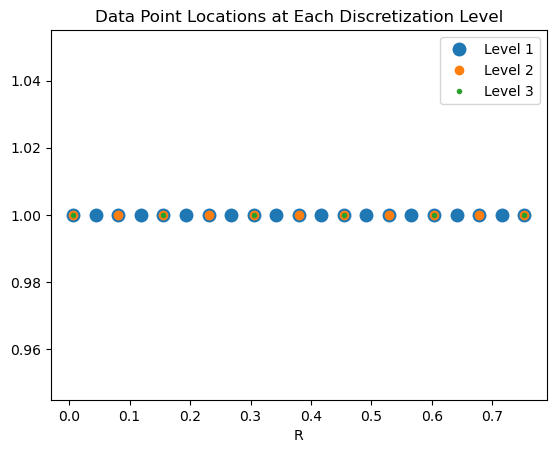

In [262]:
# Interpolate all the data (in oversampled form) to allow for a linear grid
m_intp     = interpolate.interp1d(R, m,     kind='cubic', bounds_error=False, fill_value='extrapolate')
P_intp     = interpolate.interp1d(R, P,     kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_intp   = interpolate.interp1d(R, rho,   kind='cubic', bounds_error=False, fill_value='extrapolate')
alpha_intp = interpolate.interp1d(R, alpha, kind='cubic', bounds_error=False, fill_value='extrapolate')
psi_intp   = interpolate.interp1d(R, psi,   kind='cubic', bounds_error=False, fill_value='extrapolate')

# Define the number of data points in each grid (increasingly dense), selected such to include the previous ones
n_grid1 = 6
n_grid2 = 2 * n_grid1 - 1
n_grid3 = 2 * n_grid2 - 1

# Define the range
r_min = np.min(R)
r_max = np.max(R)

# Grid definition
r_grid1 = np.linspace(r_min, r_max, n_grid1)
r_grid2 = np.linspace(r_min, r_max, n_grid2)
r_grid3 = np.linspace(r_min, r_max, n_grid3)

# Grid visualization
if flag_check_visualization:
    # Check whether the denser grid includes the previous grid
    print(f"Valid discretization refinement: {np.all(np.isin(r_grid1, r_grid2)) and np.all(np.isin(r_grid2, r_grid3))}")  

    # Visualization 
    plt.plot(r_grid3, np.ones_like(r_grid3), marker='.', ls='none', ms = 18, label='Level 1')
    plt.plot(r_grid2, np.ones_like(r_grid2), marker='.', ls='none', ms = 12, label='Level 2')
    plt.plot(r_grid1, np.ones_like(r_grid1), marker='.', ls='none', ms = 6, label='Level 3')
    plt.title("Data Point Locations at Each Discretization Level")
    plt.xlabel("R")
    plt.legend();

# Define a fine test grid
n_grid_test = 5000
r_grid_test = np.linspace(r_min, r_max, n_grid_test)


## 1. Application of a perturbation to the density

In [263]:
# The code below will be put in a for loop over the different discretizations
r_grid = r_grid1

# Definitions
iteration_steps = 100

# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-2     # Scale factor

# Construction of the perturbation for r_grid_test
center_index  = np.argmin(np.abs(r_grid_test - center_value))
r_centered    = (r_grid_test - r_grid_test[center_index])/r_grid_test[center_index]
gaussian      = amplitude * np.exp(-((r_grid_test - r_grid_test[center_index]) ** 2) / (2 * sigma**2))
density_perturbation_test  = gaussian * r_centered

# Interpolate and define for r_grid
density_perturbation_interp = interpolate.interp1d(r_grid_test, density_perturbation_test, kind='cubic', bounds_error=False, fill_value='extrapolate')
density_perturbation = density_perturbation_interp(r_grid)

## 2. Construction of a Ground Truth (Numerical) Solution

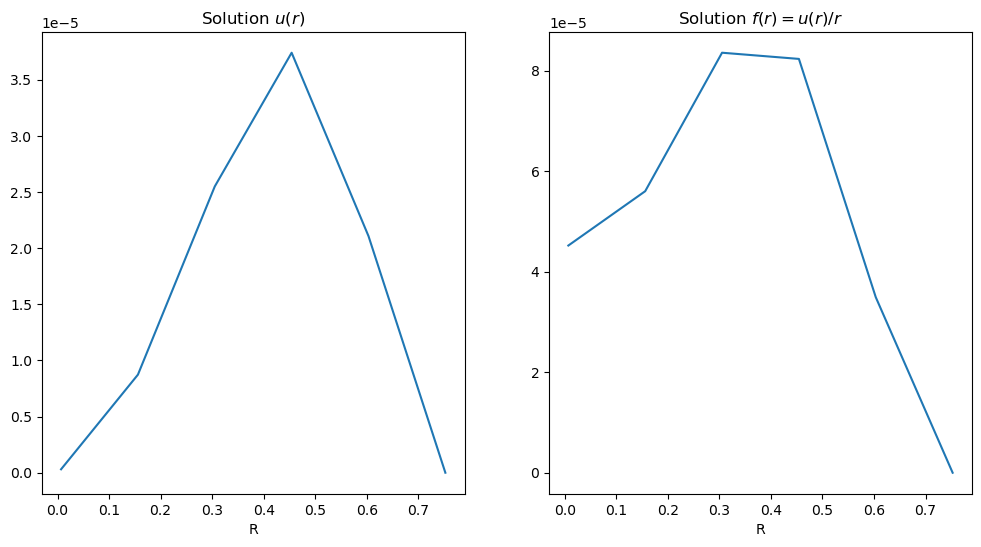

In [264]:
# Sample all the data with the selected grid
m     = m_intp(r_grid)  
P     = P_intp(r_grid)   
rho   = rho_intp(r_grid)  
alpha = alpha_intp(r_grid) 
psi   = psi_intp(r_grid) 

# Express the source/matter terms
W  = 1                                         # Lorentz factor
v  = np.zeros_like(rho)                        # radial velocity

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P


# Definition of the ODE
S1           = - 2*np.pi*rho
dS1          = -2*np.pi*density_perturbation
k_squared1   = - S1/psi**(2)
source_term1 = dS1 / psi

# Interpolate the numerically determined functions
k_squared1_interp   = interpolate.interp1d(r_grid, k_squared1,   kind='cubic', bounds_error=False, fill_value='extrapolate')
source_term1_interp = interpolate.interp1d(r_grid, source_term1, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Conversion of the 2nd order ODE to a 1st order system of ODEs defining a state vector y such that y[0] = u, and y[1] = du/dr
def fun(r, y):
    u   = y[0]
    du  = y[1]
    ddu = k_squared1_interp(r) * u + r * source_term1_interp(r)
    return np.vstack((du, ddu))

# Define the boundary conditions:
def bc(ya, yb):
    r0 = r_grid[0]  # first grid point, e.g. 0.005
    return np.array([ya[0] - r0 * ya[1],  # inner BC: u(r0) - r0*u'(r0)=0
                     yb[0]             ])  # outer BC: u(R) = 0

# Initial guess for solution y: two components, u and du/dr
y_guess  = np.zeros((2, r_grid.size))

# Solve BVP
sol = solve_bvp(fun, bc, r_grid, y_guess)

# Recover f(r) = u(r)/r
u = sol.y[0]
f = u / r_grid

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(r_grid, u)
ax[0].set_xlabel('R');
ax[0].set_title(r"Solution $u(r)$")

ax[1].plot(r_grid, f);
ax[1].set_xlabel('R');
ax[1].set_title(r"Solution $f(r) = u(r)/r$");


## 3. Single Iterative Step of the Probabilistic Numerical Approach

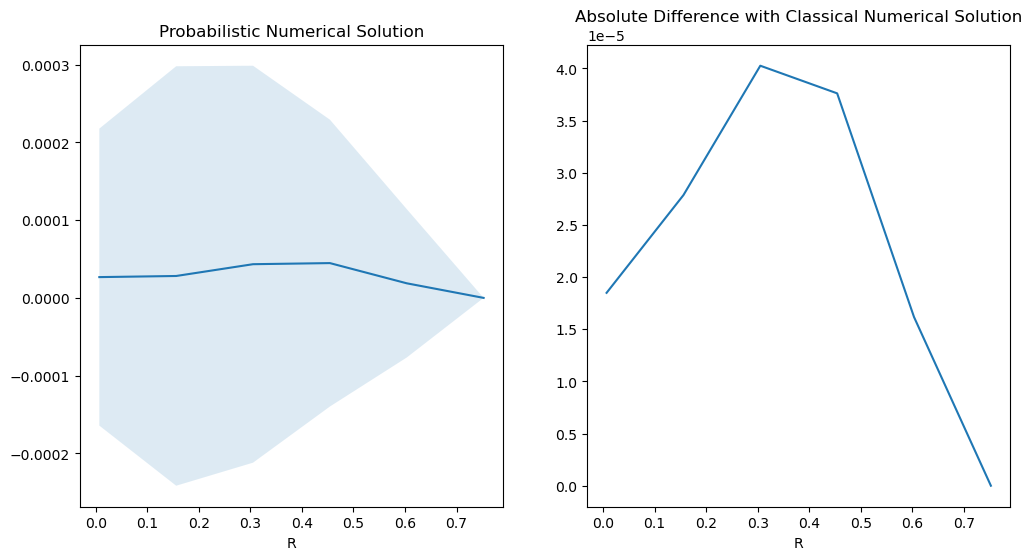

In [265]:
# Function definitions 
def construct_design_matrix(S1, dS1, r_domain, basis_func, laplacian, psi, N):
    # Definition of k_squared and the source term
    k_squared   = - S1/psi**(2)
    source_term = dS1 / psi

    # Lambdify the basis functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    
    # Initialization of the design matrix
    design_matrix = np.zeros((len(r_domain), N))
    basis_func_matrix = np.zeros((len(r_domain), N))

    for i in range(1, N):
        # Define the first part of the operator
        operator_part_1 = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))(r_domain, i, max(r_domain))
        operator_part_2 = -k_squared*basis_func_lambd(r_domain, i, max(r_domain))
    
        design_matrix[:,i] = operator_part_1 + operator_part_2
        basis_func_matrix[:,i] = basis_func_lambd(r_domain, i, max(r_domain))

    return basis_func_matrix, design_matrix, source_term

def solve_ode(basis_func_matrix, design_matrix, y, S, L):
    # Define the (inverse) squared lambda and sigma matrices
    Sneg2 = np.linalg.matrix_power(S, -2)
    Lneg2 = np.linalg.matrix_power(L, -2)
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    A = design_matrix.T @ Sneg2 @ design_matrix + Lneg2
    b = design_matrix.T @ Sneg2 @ y
    
    # Solve the system
    w = np.linalg.solve(A, b)
    
    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(A, design_matrix.T)
    source_func_variance_primal = design_matrix @ v
    source_func_variance_primal = np.diag(source_func_variance_primal)
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(A, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v
    solution_variance_primal = np.diag(solution_variance_primal)

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, w, A

# Definition of S1 and dS1
S1           = -2*np.pi*rho
dS1          = -2*np.pi*density_perturbation

# Symbol nomenclature
r = sp.symbols('r')
n = sp.symbols('n')
R_max = sp.symbols('R_max')

# Define the basis functions as the eigen functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)
basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)

# Specificy the problem as: L f = g
laplacian   = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)
operator_1_lamb = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

N = 10
basis_func_matrix, design_matrix, source_term = construct_design_matrix(S1, dS1, r_grid, basis_func, laplacian, psi, N)

# Solve the ODE
S = 1.0e-3*np.identity(len(r_grid))
L = 1.0e-4*np.identity(N)
solution_mean_primal, solution_variance_primal, source_func_primal, source_func_variance_primal, w, A = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(r_grid, solution_mean_primal)
ax[0].fill_between(r_grid, solution_mean_primal - np.sqrt(solution_variance_primal), solution_mean_primal + np.sqrt(solution_variance_primal), alpha=0.15)
ax[0].set_xlabel('R');
ax[0].set_title(r"Probabilistic Numerical Solution")

ax[1].plot(r_grid, np.abs(solution_mean_primal - f));
ax[1].set_xlabel('R');
ax[1].set_title(r"Absolute Difference with Classical Numerical Solution");

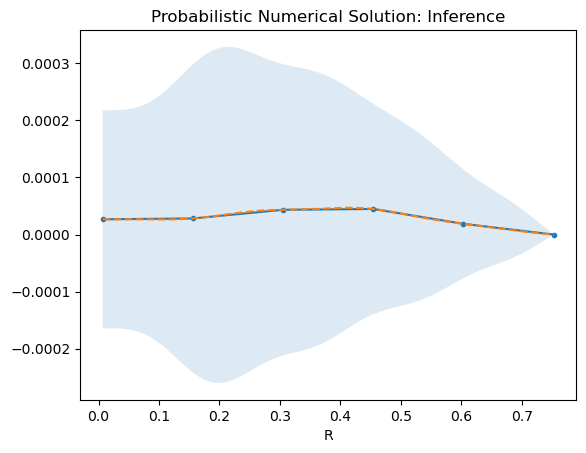

In [266]:
# Extend this to do inference on the test data points
S1           = -2*np.pi*rho_intp(r_grid_test)
dS1          = -2*np.pi*density_perturbation_interp(r_grid_test)

basis_func_matrix_test, design_matrix_test, source_term_test = construct_design_matrix(S1, dS1, r_grid_test, basis_func, laplacian, psi_intp(r_grid_test), N)

solution_mean_primal_test = basis_func_matrix_test @ w

v = np.linalg.solve(A, basis_func_matrix_test.T)
solution_variance_primal_test = basis_func_matrix_test @ v

solution_variance_primal_test = np.squeeze(np.diag(solution_variance_primal_test))

plt.plot(r_grid, solution_mean_primal, marker='.')
plt.plot(r_grid_test, solution_mean_primal_test, ls='--')
plt.fill_between(r_grid_test, solution_mean_primal_test - np.sqrt(solution_variance_primal_test), solution_mean_primal_test + np.sqrt(solution_variance_primal_test), alpha=0.15)
plt.xlabel('R');
plt.title(r"Probabilistic Numerical Solution: Inference");



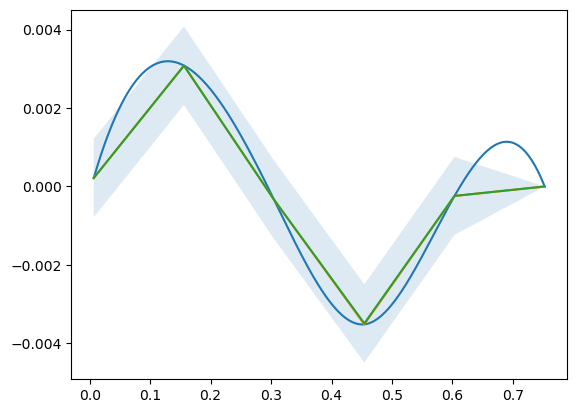

In [267]:
plt.plot(r_grid_test, source_term1_interp(r_grid_test))
plt.plot(r_grid, source_term)
plt.plot(r_grid, source_func_primal)
source_func_std = np.squeeze(np.diag(source_func_variance_primal))
plt.fill_between(r_grid, source_func_primal - np.sqrt(source_func_variance_primal), source_func_primal + np.sqrt(source_func_variance_primal), alpha=0.15)

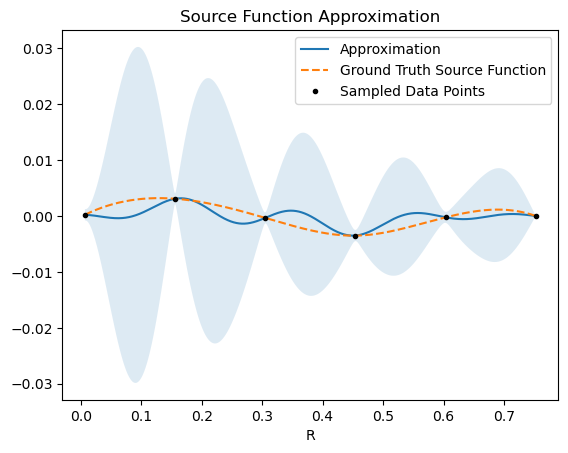

In [268]:
plt.plot(r_grid_test, design_matrix_test @ w, label="Approximation")

source_test = design_matrix_test @ w
v = np.linalg.solve(A, design_matrix_test.T)
source_func_variance_primal_test = np.sqrt(np.squeeze(np.diag(design_matrix_test @ v)))

plt.fill_between(r_grid_test, source_test - source_func_variance_primal_test, source_test + source_func_variance_primal_test, alpha=0.15)

plt.plot(r_grid_test, source_term1_interp(r_grid_test), ls='--', label="Ground Truth Source Function")

plt.plot(r_grid, design_matrix @ w, marker='.', linestyle='none', color='black', label="Sampled Data Points")

plt.xlabel("R")
plt.title("Source Function Approximation")
plt.legend()

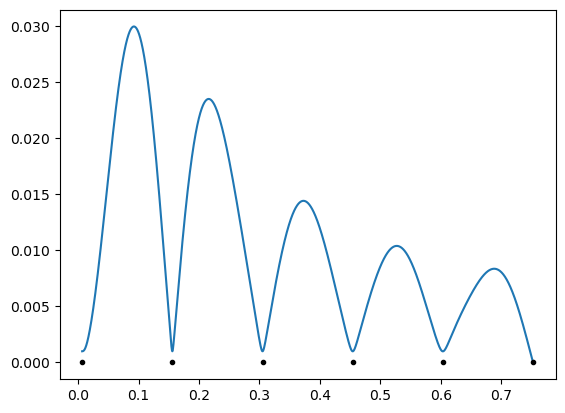

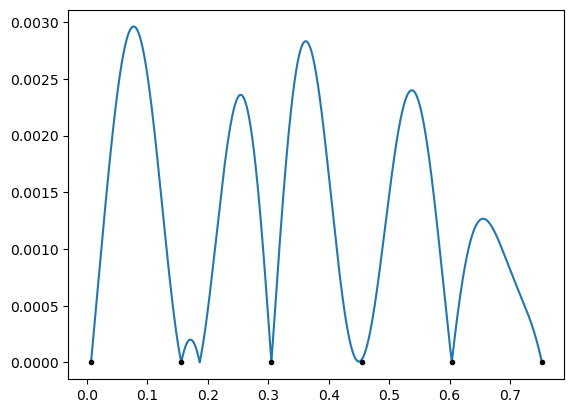

In [269]:
plt.plot(r_grid_test, source_func_variance_primal_test)
plt.plot(r_grid, np.zeros_like(r_grid), marker='.', linestyle='none', color='black', label="Sampled Data Points")

plt.figure(2)
plt.plot(r_grid_test, np.abs(source_test - source_term1_interp(r_grid_test)))
plt.plot(r_grid, np.zeros_like(r_grid), marker='.', linestyle='none', color='black', label="Sampled Data Points")
